### Get the MNIST Data

In [0]:
#!pip install tensorflow-gpu==2.0.0-alpha0

In [0]:
%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow 1.x selected.
1.15.2
/device:GPU:0
Num GPUs Available:  1


In [0]:
from google.colab import files
src = list(files.upload().values())[0]
open('input_data.py','wb').write(src)
# source :
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/mnist/input_data.py
# saved the file on local host and then uploaded

Saving input_data.py to input_data.py


12046

In [0]:
import input_data

In [0]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [0]:
type(mnist)

input_data._Datasets

In [0]:
mnist.train.images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
mnist.train.num_examples

55000

In [0]:
mnist.test.num_examples

10000

In [0]:
mnist.validation.num_examples

5000

### Visualizing the Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
mnist.train.images[1].shape

(784,)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


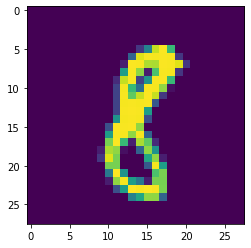

In [0]:
x_example,y_example = mnist.train.next_batch(100)
plt.imshow(x_example[1].reshape(28,28))
print(y_example[1])

In [0]:
x_example.reshape(100,28,28).shape

(100, 28, 28)

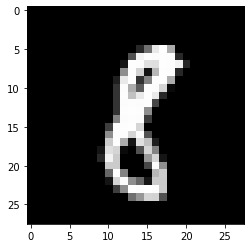

In [0]:
plt.imshow(mnist.train.images[1].reshape(28,28),cmap='gist_gray')

## Create the Model

Helper Functions

In [0]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

#def conv2d_stride(x,W):
#    return tf.nn.conv2d(x,W, strides=[1,2,2,1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def convolutional_layer_padding(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d_stride(input_x, W) + b)


def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b


Placeholders

In [0]:
x = tf.placeholder(tf.float32,shape=[None,784])
y_true = tf.placeholder(tf.float32,shape=[None,10])

In [0]:
# for dropout
hold_prob = tf.placeholder(tf.float32)

In [0]:
# for batch_normalization
#is_train = tf.placeholder(tf.bool, name="is_train")

Layers

In [0]:
x_image = tf.reshape(x,[-1,28,28,1])

In [0]:
convo_1_1 = convolutional_layer(x_image, shape=[3,3,1,32])
convo_1_2 = convolutional_layer(convo_1_1, shape=[3,3,32,32])
#convo_1_3 = convolutional_layer_padding(convo_1_2, shape=[5,5,32,32])
convo_1_pooling = max_pool_2by2(convo_1_2)
#convo_normal_1 = tf.layers.batch_normalization(convo_1_pooling, training=is_train)
convo_1_dropout = tf.nn.dropout(convo_1_pooling, keep_prob=hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
convo_2_1 = convolutional_layer(convo_1_dropout, shape=[3,3,32,64])
convo_2_2 = convolutional_layer(convo_2_1, shape=[3,3,64,64])
#convo_2_3 = convolutional_layer_padding(convo_2_2, shape=[5,5,64,64])
convo_2_pooling = max_pool_2by2(convo_2_2)
#convo_normal_2 = tf.layers.batch_normalization(convo_2_pooling, training=is_train)
convo_2_dropout = tf.nn.dropout(convo_2_pooling, keep_prob=hold_prob)

In [0]:
convo_2_flat = tf.reshape(convo_2_dropout,[-1,7*7*64])
# using n_out = [(n_in+2p-k)/s]+1

In [0]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,128))
#full_layer_one_normal = tf.layers.batch_normalization(full_layer_one,training=is_train)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [0]:
y_pred = normal_full_layer(full_one_dropout,10)

Loss and Optimizer

In [0]:
# Loss Function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [0]:
# Accuracy
matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(matches,tf.float32))

### Create Session

In [0]:
init = tf.global_variables_initializer()

In [0]:
steps = 10000

with tf.Session() as sess:
  
  sess.run(init)

  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy = []
  summary_writer = tf.summary.FileWriter('./Output', sess.graph)

  for i in range(steps):
    batch_x, batch_y = mnist.train.next_batch(50)

    opt = sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.6})#,is_train:True})

    loss, acc = sess.run([cross_entropy,accuracy],feed_dict={x:batch_x,y_true:batch_y,hold_prob:1.0})#,is_train:False})

    val_loss,test_acc = sess.run([cross_entropy,accuracy],feed_dict={x:mnist.test.images,y_true:mnist.test.labels,hold_prob:1.0})#,is_train:False})

    

    if i%100 == 0:

      print("ON STEP: {}".format(i))

      print("LOSS:")
      print(loss)

      print("TRAINING ACCURACY:")
      print(acc)
      
      print("TESTING ACCURACY:")
      print(test_acc)
      print('\n')

      if i>= 500:

        train_loss.append(loss)
        test_loss.append(val_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)

ON STEP: 0
LOSS:
2.5603747
TRAINING ACCURACY:
0.16
TESTING ACCURACY:
0.0873


ON STEP: 100
LOSS:
0.70175326
TRAINING ACCURACY:
0.84
TESTING ACCURACY:
0.7874


ON STEP: 200
LOSS:
0.49512947
TRAINING ACCURACY:
0.84
TESTING ACCURACY:
0.9204


ON STEP: 300
LOSS:
0.18482323
TRAINING ACCURACY:
0.96
TESTING ACCURACY:
0.9448


ON STEP: 400
LOSS:
0.16379362
TRAINING ACCURACY:
0.92
TESTING ACCURACY:
0.9609


ON STEP: 500
LOSS:
0.17888455
TRAINING ACCURACY:
0.94
TESTING ACCURACY:
0.9681


ON STEP: 600
LOSS:
0.055955373
TRAINING ACCURACY:
1.0
TESTING ACCURACY:
0.9722


ON STEP: 700
LOSS:
0.079509266
TRAINING ACCURACY:
0.96
TESTING ACCURACY:
0.9733


ON STEP: 800
LOSS:
0.06952024
TRAINING ACCURACY:
0.98
TESTING ACCURACY:
0.9782


ON STEP: 900
LOSS:
0.093126565
TRAINING ACCURACY:
0.96
TESTING ACCURACY:
0.9732


ON STEP: 1000
LOSS:
0.05150751
TRAINING ACCURACY:
0.98
TESTING ACCURACY:
0.9783


ON STEP: 1100
LOSS:
0.030536385
TRAINING ACCURACY:
1.0
TESTING ACCURACY:
0.9784


ON STEP: 1200
LOSS:
0.01193

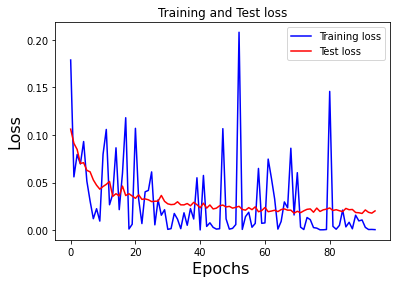

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

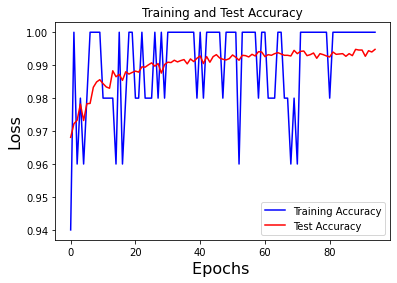

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()